In [1]:
# imports

from multipathogen_sero.io import load_metadata_json
from multipathogen_sero.config import MODEL_FITS_DIR
from multipathogen_sero.analyse_chains import *

2025-09-13 12:34:14.844 | INFO     | multipathogen_sero.config:<module>:12 - PROJ_ROOT path is: /home/ayan/sero/multipathogen-sero


In [ ]:
expt_settings = load_metadata_json(MODEL_FITS_DIR / "j0" / "a3")

fit_frailty = read_fit_csv_dir(MODEL_FITS_DIR / "j0" / "a3" / "frailty")
fit_no_frailty = read_fit_csv_dir(MODEL_FITS_DIR / "j0" / "a3" / "no_frailty")
idata_frailty = az.from_cmdstanpy(fit_frailty)
idata_no_frailty = az.from_cmdstanpy(fit_no_frailty)

frailty_summary = basic_summary(idata_frailty)
print(frailty_summary.head(20))

                            mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
baseline_hazards[0]         0.06  0.01    0.04     0.07       0.00     0.00   
baseline_hazards[1]         0.10  0.01    0.08     0.12       0.00     0.00   
seroreversion_rates[0]      0.10  0.01    0.07     0.12       0.00     0.00   
seroreversion_rates[1]      0.10  0.01    0.07     0.12       0.00     0.00   
betas[0]                   -1.03  0.37   -1.74    -0.44       0.02     0.03   
betas[1]                    0.90  0.23    0.50     1.33       0.01     0.01   
log_frailty_std             0.19  0.15    0.01     0.49       0.02     0.01   
log_frailty_deviations[0]   0.75  0.65    0.01     2.00       0.04     0.04   
log_frailty_deviations[1]   0.64  0.56    0.01     1.79       0.04     0.03   
log_frailty_deviations[2]   0.73  0.59    0.01     1.93       0.04     0.03   
log_frailty_deviations[3]   0.86  0.60    0.01     1.87       0.04     0.03   
log_frailty_deviations[4]   1.01  0.60    0.01     2

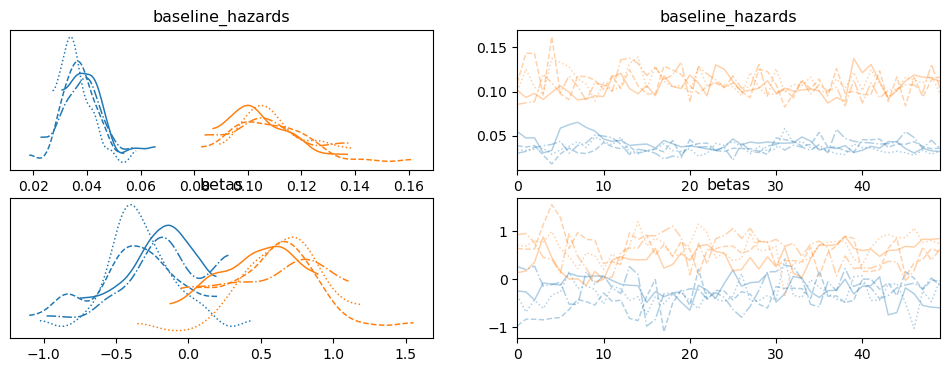

In [ ]:
axes = trace_plot(idata_frailty, var_names = ["baseline_hazards", "betas", "log_frailty_std"])

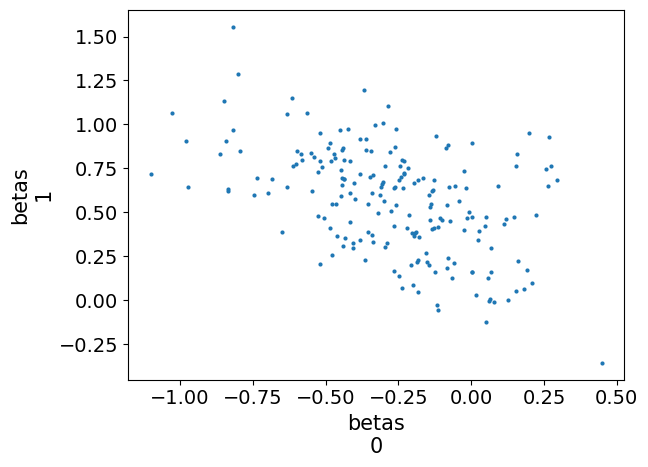

In [ ]:
axes = pairs_plot(idata_frailty)

{'betas': [1, 1], 'log_frailty_std': [0], 'baseline_hazards': [1, 1], 'seroreversion_rates': [1, 1]}


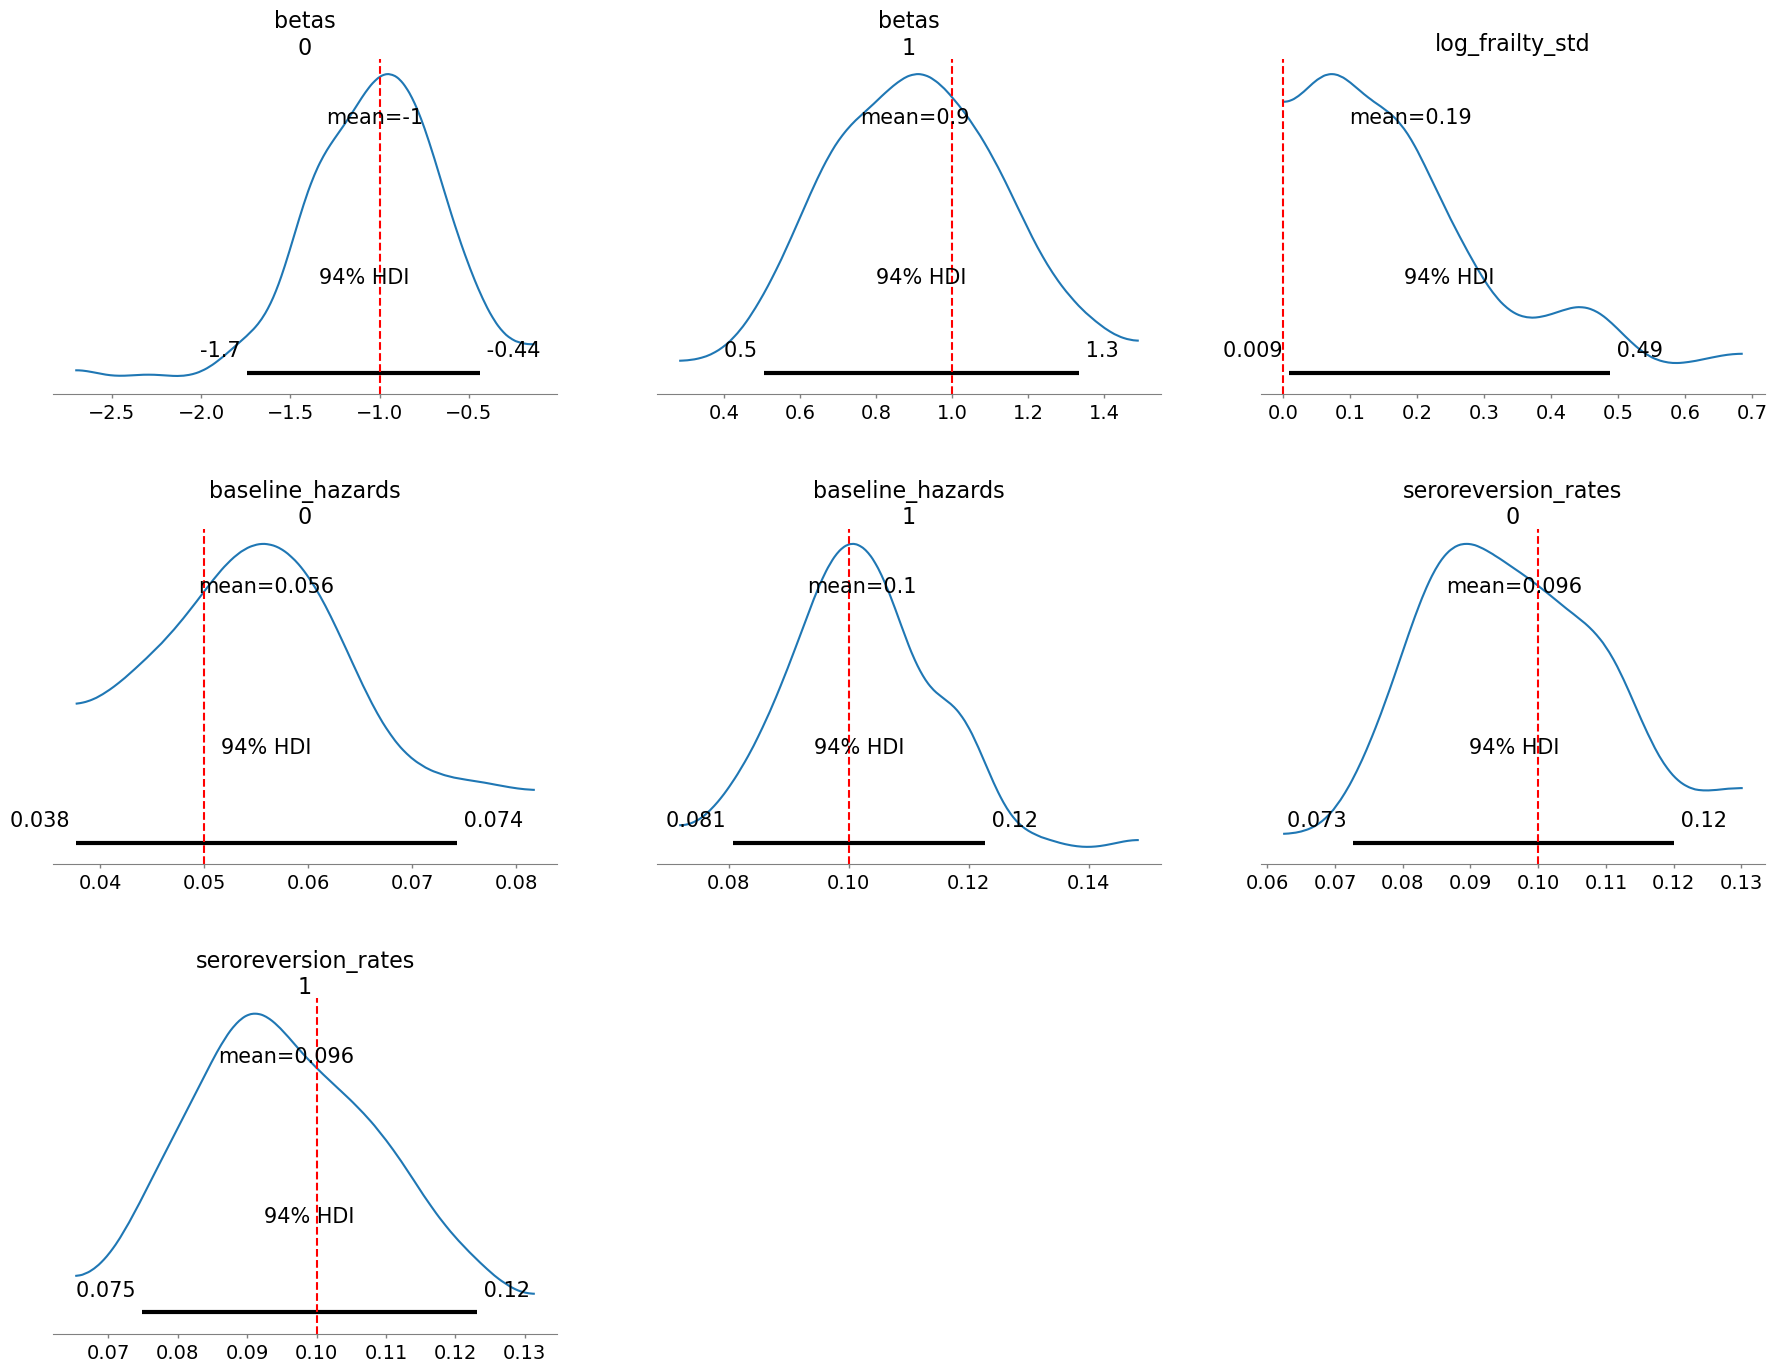

In [39]:
ground_truth_betas = [
    expt_settings["ground_truth_params"]["beta_mat"][0][1],
    expt_settings["ground_truth_params"]["beta_mat"][1][0]
]
axes, coverage = posterior_plot(
    idata_frailty, 
    var_names=["betas", "log_frailty_std", "baseline_hazards", "seroreversion_rates"],
    ground_truth={
        "betas": ground_truth_betas,
        "log_frailty_std": expt_settings["ground_truth_params"]["log_frailty_std"],
        "baseline_hazards": expt_settings["ground_truth_params"]["baseline_hazards"],
        "seroreversion_rates": expt_settings["ground_truth_params"]["seroreversion_rates"]
    }
)
print(coverage)

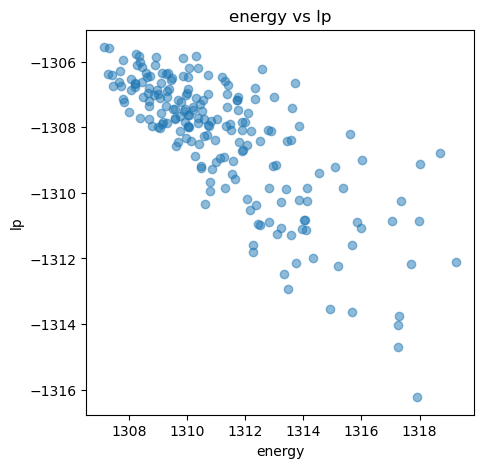

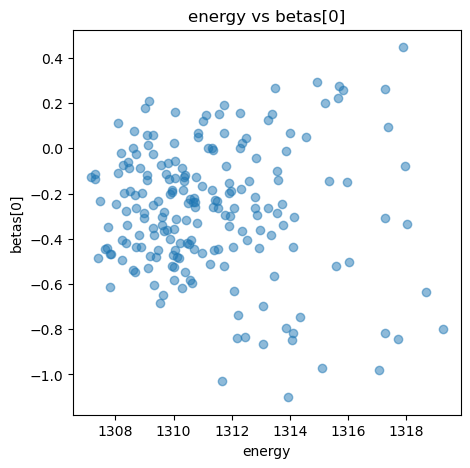

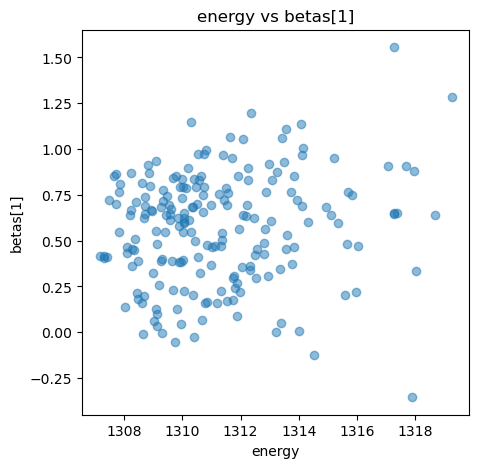

In [32]:
plot_energy_vs_lp_and_params(idata_frailty, var_names=["betas", "log_frailty_std"])

In [36]:
OUTPUT_DIR = MODEL_FITS_DIR / "j0" / "a1"

elpd_frailty, se_elpd_frailty, _ = elpd_using_test_set(
    idata_frailty
)
elpd_no_frailty, se_elpd_no_frailty, _ = elpd_using_test_set(
    idata_no_frailty
)
elpd_diff, se_elpd_diff = compare_using_test_set(
    idata_frailty,
    idata_no_frailty
)
elpd_report = f"""
elpd (frailty model): {elpd_frailty} (SE: {se_elpd_frailty})
elpd (no frailty model): {elpd_no_frailty} (SE: {se_elpd_no_frailty})
elpd difference (frailty - no frailty): {elpd_diff} (SE: {se_elpd_diff})
"""
with open(OUTPUT_DIR / "elpd_report.txt", "w") as f:
    f.write(elpd_report)

# playground

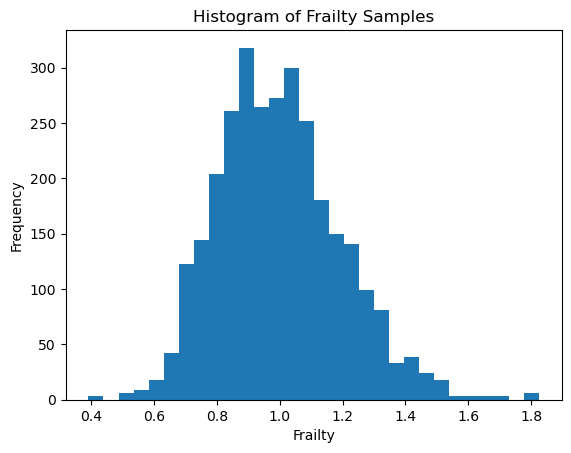

Mean frailty: 0.99819309351439


In [43]:
import numpy as np
import matplotlib.pyplot as plt

log_frailty_covariance = np.ones((3, 3))*0.2**2  # Ensure shape is (3,3)

# Generate 100 i.i.d. samples
indiv_log_frailty_samples = np.random.multivariate_normal(
    -0.5 * np.diag(log_frailty_covariance), log_frailty_covariance, size=1000
)
indiv_frailty_samples = np.exp(indiv_log_frailty_samples)

# Flatten for histogram (if you want all values together)
flat_frailty = indiv_frailty_samples.flatten()

# Plot histogram
plt.hist(flat_frailty, bins=30)
plt.xlabel('Frailty')
plt.ylabel('Frequency')
plt.title('Histogram of Frailty Samples')
plt.show()

# Report mean
mean_frailty = flat_frailty.mean()
print("Mean frailty:", mean_frailty)

In [2]:
from multipathogen_sero.models.model import PairwiseModel
from multipathogen_sero.config import LOCAL_MODEL_FITS_DIR
from multipathogen_sero.analyse_chains import elpd_using_test_set, compare_using_test_set
output_dir = LOCAL_MODEL_FITS_DIR / "local_j20250917224215"/"a1"
# enumerate the subfolders of output_dir
output_subdirs = {
    subdir.name: subdir
    for subdir in output_dir.iterdir()
    if subdir.is_dir()
}

# Assuming output_subdirs is already defined as in your script
models = {}
for model_name, fit_dir in output_subdirs.items():
    models[model_name] = PairwiseModel.load_fit(fit_dir)

# do elpd
elpd_frailty, se_elpd_frailty, _ = elpd_using_test_set(
    models["frailty"].idata
)
elpd_no_frailty, se_elpd_no_frailty, _ = elpd_using_test_set(
    models["no_frailty"].idata
)
elpd_frailty_known, se_elpd_frailty_known, _ = elpd_using_test_set(
    models["frailty_known"].idata
)
elpd_diff_frailty_no_frailty, se_elpd_diff_frailty_no_frailty = compare_using_test_set(
    models["frailty"].idata,
    models["no_frailty"].idata
)
elpd_diff_frailty_known_no_frailty, se_elpd_diff_frailty_known_no_frailty = compare_using_test_set(
    models["frailty_known"].idata,
    models["no_frailty"].idata
)
elpd_diff_frailty_frailty_known, se_elpd_diff_frailty_frailty_known = compare_using_test_set(
    models["frailty"].idata,
    models["frailty_known"].idata
)
elpd_report = f"""
elpd (frailty model): {elpd_frailty} (SE: {se_elpd_frailty})
elpd (no frailty model): {elpd_no_frailty} (SE: {se_elpd_no_frailty})
elpd difference (frailty - no frailty): {elpd_diff_frailty_no_frailty} (SE: {se_elpd_diff_frailty_no_frailty})
elpd (frailty known model): {elpd_frailty_known} (SE: {se_elpd_frailty_known})
elpd difference (frailty known - no frailty): {elpd_diff_frailty_known_no_frailty} (SE: {se_elpd_diff_frailty_known_no_frailty})
elpd difference (frailty - frailty known): {elpd_diff_frailty_frailty_known} (SE: {se_elpd_diff_frailty_frailty_known})
"""
with open(output_dir / "elpd_report.txt", "w") as f:
    f.write(elpd_report)


In [5]:
print(elpd_report)


elpd (frailty model): -1114.3636101785446 (SE: 48.03127439814543)
elpd (no frailty model): -1113.3357042739171 (SE: 47.863933138063004)
elpd difference (frailty - no frailty): -1.0279059046275703 (SE: 1.3727926132671349)
elpd (frailty known model): -1122.299107730279 (SE: 48.71655618573125)
elpd difference (frailty known - no frailty): -8.963403456362066 (SE: 4.325052199284444)
elpd difference (frailty - frailty known): 7.935497551734496 (SE: 2.9704551683394236)

